install non-standard dependencies:
- `conda install keras tensorflow`
- `conda install deepdish -c conda-forge`
- `pip install git+http://github.com/postpop/videoreader`
- `pip install git+http://github.com/janclemenslab/dataloader`
- `pip install git+http://github.com/janclemenslab/leap_utils.git --process-dependency-links`


In [1]:
import h5py
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dataloader import DataLoader

import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

from leap_utils.train import points2mask
from leap_utils.plot import color_confmaps, boxpos, confmaps
from leap_utils.postprocessing import process_confmaps_simple
from leap_utils.predict import predict_confmaps, load_network
from leap_utils.preprocessing import get_box, export_boxes, angles, normalize_boxes

root_dir = '/Volumes/ukme04/#Common/chainingmic'
dl = DataLoader(root_dir)
expt_id = 'localhost-20181212_111224'
vr = dl.get('video', expt_id)
poses = dl.get('poses', expt_id)

# positions = poses['positions']
# box_centers = poses['box_centers']
box_angles = poses['fixed_angles']
# box_size = poses['box_size']


Using TensorFlow backend.


In [22]:
import deepdish as dd
# posespath = dl.path('poses', expt_id)[:-3] + '_withprior.h5';
# network_path = root_dir + '/leap/training_data/res/leap_local_cnn_split_20190110_1342.best'#'/leap/best_model.h5'

posespath = dl.path('poses', expt_id)[:-3] + '_withoutprior.h5';
network_path = root_dir + '/leap/training_data/res/leap_cnn_20190110_1342.best'#'/leap/best_model.h5'

# posespath = dl.path('poses', expt_id)[:-3] + '_backup.h5';
# network_path = root_dir + '/leap/best_model.h5'
print(posespath)
poses = dd.io.load(posespath)

positions = poses['positions']
box_centers = poses['box_centers']
box_angles = poses['fixed_angles']
box_size = poses['box_size']

print(network_path)
network = load_network(network_path, image_size=box_size)


/Volumes/ukme04/#Common/chainingmic/res/localhost-20181212_111224/localhost-20181212_111224_poses_withoutprior.h5
/Volumes/ukme04/#Common/chainingmic/leap/training_data/res/leap_cnn_20190110_1342.best


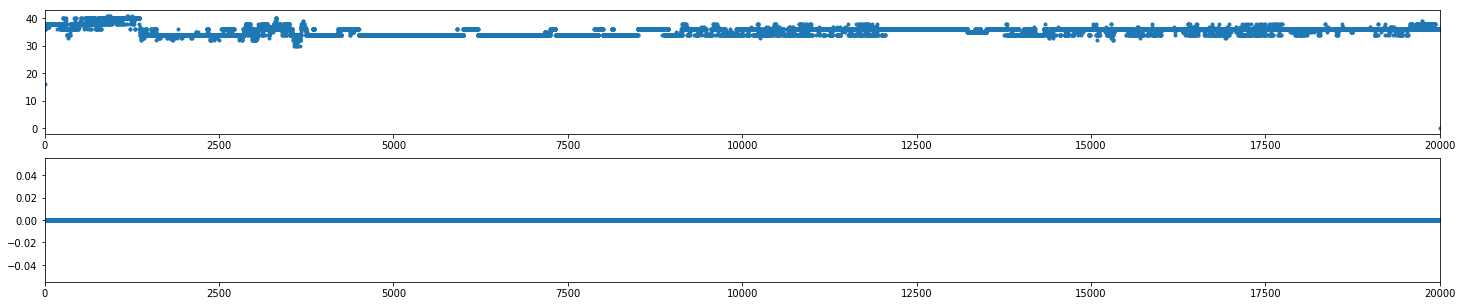

In [23]:
# plot poses
plt.gcf().set_size_inches(25,5)
plt.subplot(211)
plt.plot(positions[:,0,0], '.')
plt.xlim(0, positions.shape[0])
plt.subplot(212)
plt.plot(np.isnan(positions[:,0,0]), '.')
plt.xlim(0, positions.shape[0]);

uint8


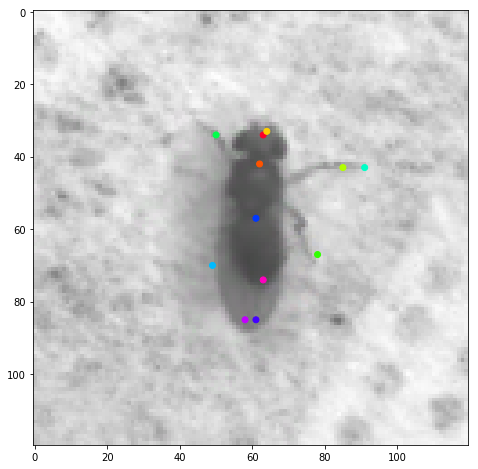

In [24]:
# overlay body part positions on fly
fn = 29701  # fly on the side
# fn = 45101  # fly on the side
fn = 2222  # frame_number

plt.gcf().set_size_inches(16,8)
# get box corresponding to current fly/frame and overlay positions of body parts
box = get_box(vr[fn], box_centers[fn, ...], box_size, box_angles[fn, ...])
print(box.dtype)
boxpos(box, positions[fn, ...])

0.2784314 0.99607843


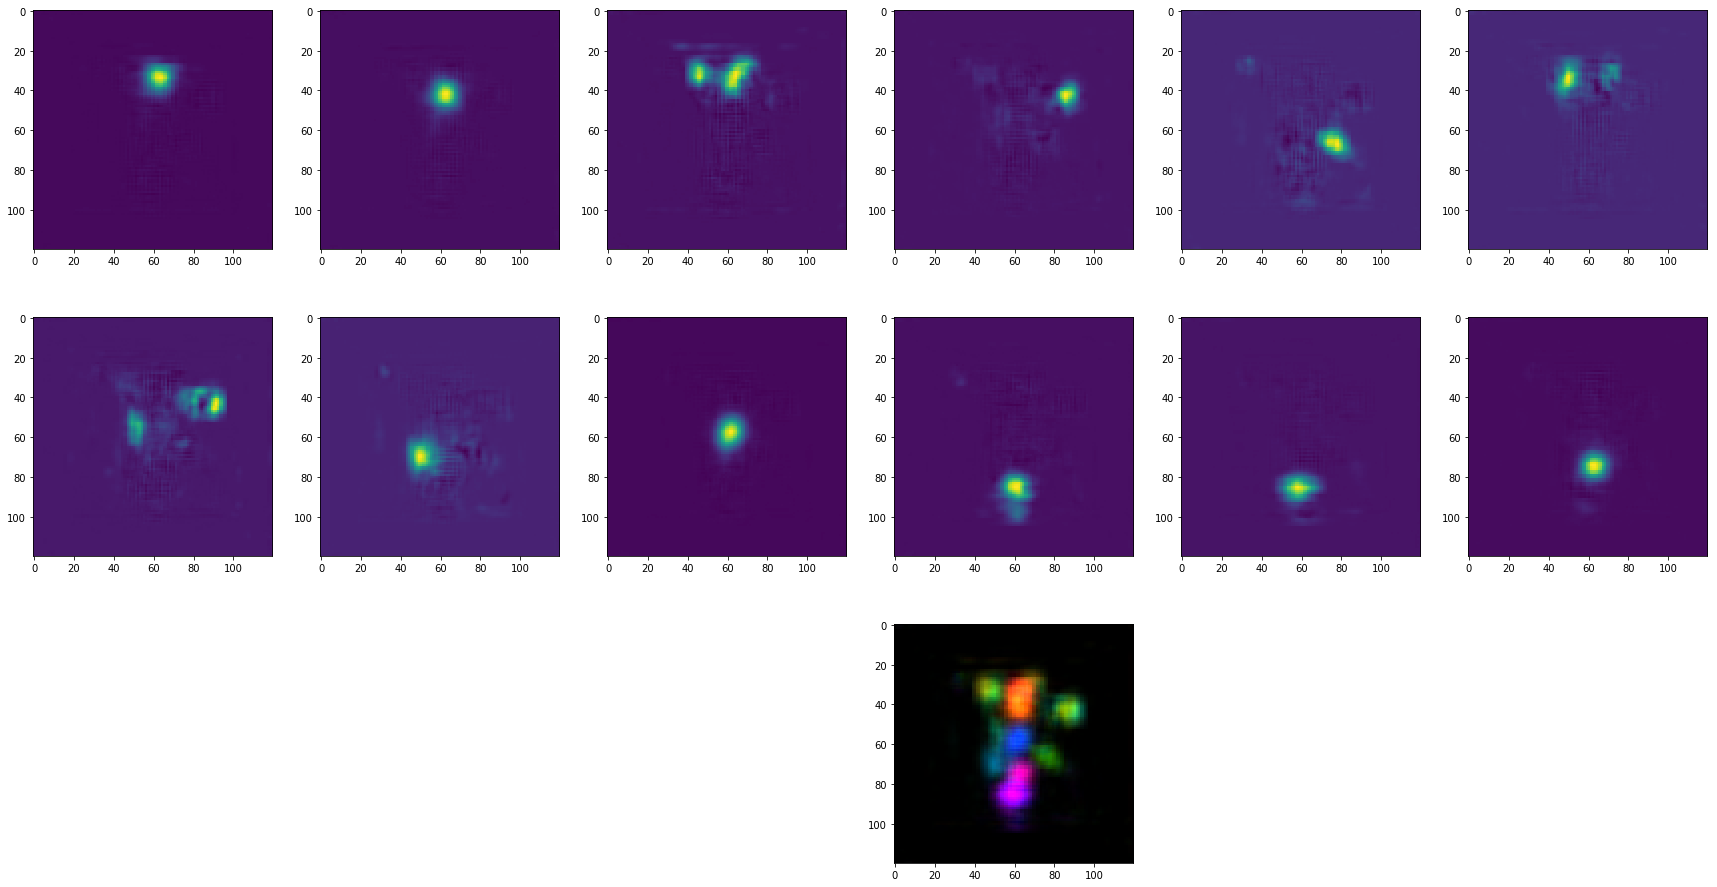

In [25]:
fns = [2222,]  # list of frames
frames = list(vr[fns])  # load all frames in fns
boxes, *_ = export_boxes(frames, box_centers[fns, np.newaxis, ...], box_size, box_angles[fns, np.newaxis, ...])
boxes = normalize_boxes(boxes)  # scales boxes to [-1, 1], etc
print(np.min(boxes[0,...,0]), np.max(boxes[0,...,0]))
cm = predict_confmaps(network, boxes[:, :, :, :1])
positions_new, confidence = process_confmaps_simple(cm)

plt.gcf().set_size_inches(30, 16)
for cnt in range(12):
    plt.subplot(3,6,cnt+1)
    plt.imshow(cm[0, ..., cnt])

plt.subplot(3,6,16)
confmaps(cm[0,...])
    

In [26]:
fns = range(2000, 16000, 1000)  # list of frames
frames = list(vr[fns])  # load all frames in fns
boxes, *_ = export_boxes(frames, box_centers[fns, np.newaxis, ...], box_size, box_angles[fns, np.newaxis, ...])
boxes = normalize_boxes(boxes)  # scales boxes to [-1, 1], etc

cm = predict_confmaps(network, boxes[:, :, :, :1])
positions_new, confidence = process_confmaps_simple(cm)

(14, 120, 120, 12) range(2000, 16000, 1000)


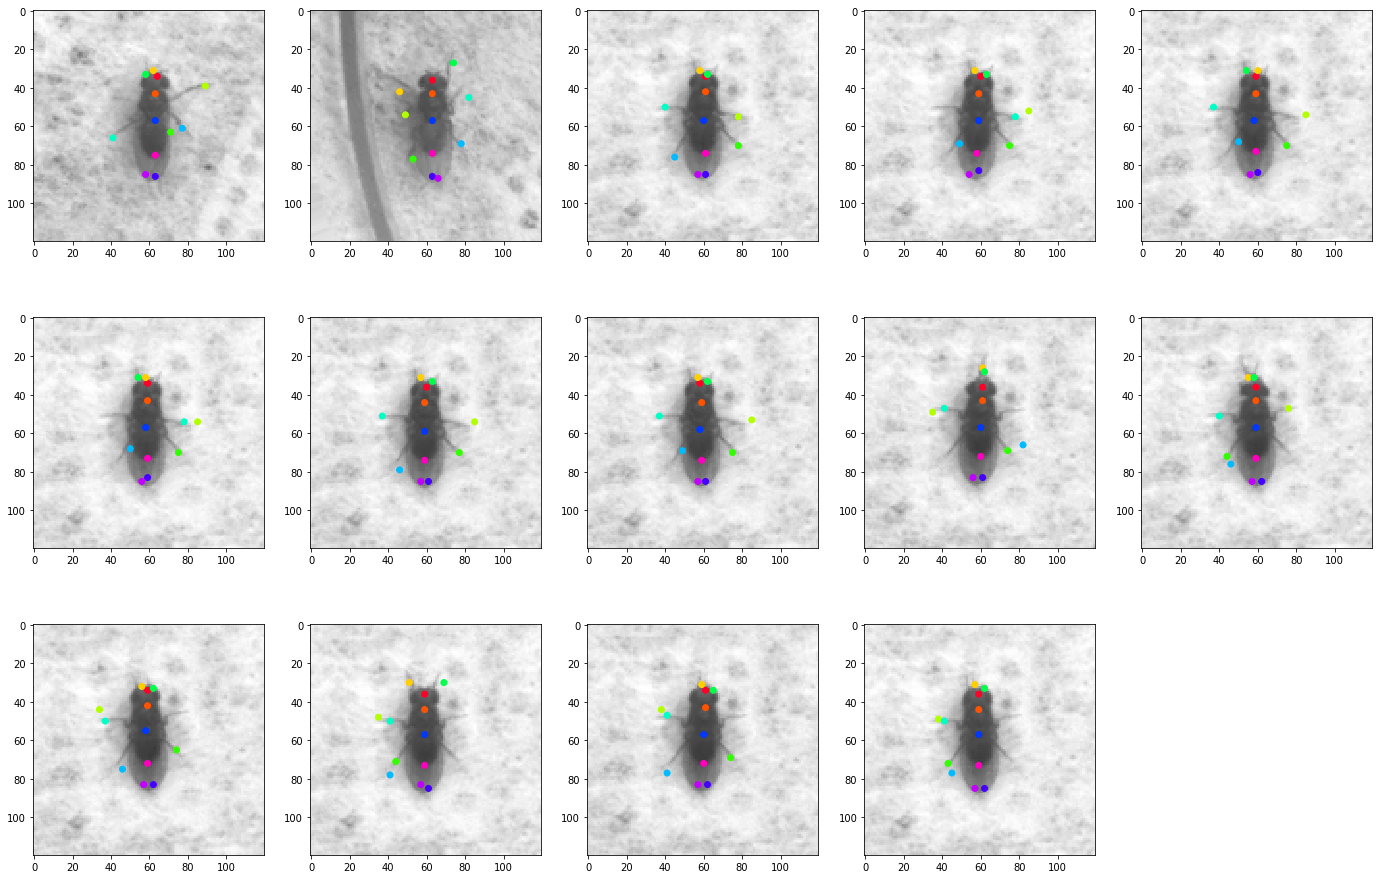

In [27]:
# plot confidence maps
plt.gcf().set_size_inches(24, 16)
print(cm.shape, fns)
for cnt, cmi in enumerate(cm):
    plt.subplot(3,5,cnt+1)
    #     confmaps(cmi)
    boxpos(boxes[cnt,...], positions_new[cnt, ...])